In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import numpy as np
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import imageio.v3 as iio
np.set_printoptions(formatter={"float": "{:10.2f}".format})

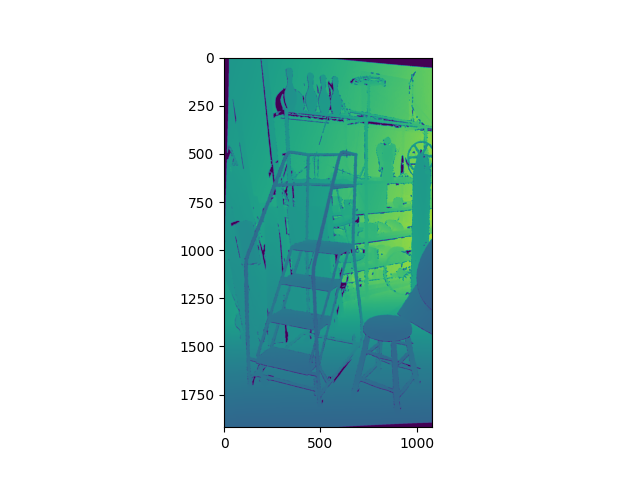

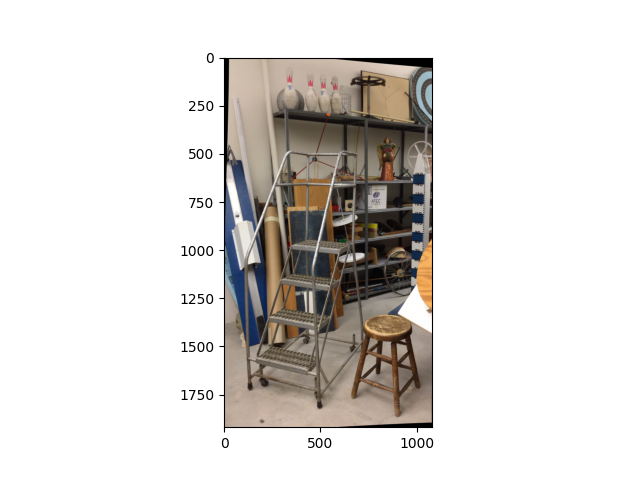

In [27]:
img_path = "~/data/middlebury/all/data/ladder1/im0.png"
dispm_path = "~/data/middlebury/all/data/ladder1/disp0.pfm"
f = 1733.68
cam = np.array([[f, 0, 819.72], [0, f, 957.55], [0, 0, 1]])
baseline=221.13
doffs=0

pfm = iio.imread(dispm_path,plugin="PFM-FI").astype(np.float32)


for y in range(pfm.shape[0]):
    for x in range(pfm.shape[1]):
        disp = pfm[y,x]
        if disp != 0:
            Z = baseline * f / (disp + doffs)
        else:
            Z = np.nan
        pfm[y,x] = Z

dm = np.flip(pfm,axis=0).copy()

im = iio.imread(img_path)
im = np.asarray(im)

plt.figure()
plt.imshow(dm)

plt.figure()
plt.imshow(im)


In [28]:
pts = []
invK = la.inv(cam)
for y in range(dm.shape[0]):
    for x in range(dm.shape[1]):
        dist = dm[y,x]
        pt = dist * (invK @ [x,y,1])
        pts.append(pt)

pts = np.array(pts)

In [29]:
#mesh['colors'] = my_rgb_array
#mesh.plot(scalars='colors', rgb=True, notebook=False)

mesh = pv.PolyData(pts)
mesh['colors'] = np.reshape(im,(-1,3))

#mesh.plot(scalars='colors',rgb=True, render_points_as_spheres=True,eye_dome_lighting=True,notebook=False)
mesh.plot(scalars='colors',rgb=True,notebook=False,point_size=0.5)

In [50]:
from src.dmcpworkflow.annotate_points import annotate
import matplotlib as mpl
#print(f"interactive matplotlib: {plt.isinteractive()}")
mpl.use("TKAgg")
cps = annotate(im[:,:,0],dm) # exactly nonplanar 6 do seem best
%matplotlib inline
#print(cps)

In [51]:
#cps[:,2:] = cps[:,:2]

In [52]:
#cps = np.array([[ 340.53626943,  498.71808761,  340.53626943,  498.71808761],
#       [ 441.31010699,  514.22175493,  441.31010699,  514.22175493],
#       [ 689.36878407,  506.46992127,  689.36878407,  506.46992127],
#       [ 619.60228114,  496.13414306,  619.60228114,  496.13414306],
#       [ 131.23676065, 1568.47113249,  131.23676065, 1568.47113249],
#       [ 492.98899805, 1661.4931364 ,  492.98899805, 1661.4931364 ],
#       [ 418.05460602, 1436.6899603 ,  418.05460602, 1436.6899603 ],
#       [ 715.20822959, 1488.36885136,  715.20822959, 1488.36885136]])

#cps = np.array([[    702.29,    1677.00   ,  704.87  ,  1679.58],
# [    898.67  ,  1757.10   ,  898.67 ,   1754.52],
# [   1002.03,    1674.41 ,    994.27  ,  1664.08],
# [    968.43 ,   1540.05,     968.43  ,  1545.22],
# [    890.92 ,   1586.56,     885.75   , 1583.97],
# [    735.88 ,   1532.30   ,  738.46   , 1534.88],
# [    141.57 ,    863.05   ,  138.99  ,   870.81]])

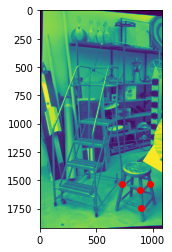

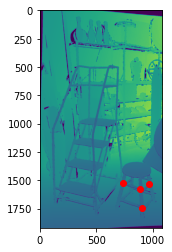

In [53]:
plt.figure()
plt.imshow(im[:,:,0])
plt.scatter(cps[:,0],cps[:,1],c="r")

plt.figure()
plt.imshow(dm,origin="upper")
plt.scatter(cps[:,2],cps[:,3],c="r")

plt.show()

In [54]:
from src.pycv.dmcp import dm_to_world
ext = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
P_gt = cam @ ext

world_pts = dm_to_world(dm, cam, P_gt,cps[:,2:])
world_pts

array([[   -315.69,    2152.57,    6628.13],
       [    244.56,    2254.95,    6268.55],
       [    593.04,    2288.33,    6885.03],
       [    292.24,    2846.08,    6269.37]], dtype=float32)

### annotated world points

In [55]:
import pyvista as pv
cps_mesh = pv.PolyData(world_pts)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True, render_points_as_spheres=True, point_size=0.5)
pl.add_mesh(cps_mesh, color="red", point_size=15, render_points_as_spheres=True)
pl.show()

### current dmcp result

In [56]:
from src.pycv.dmcp import dmcp
R  = np.array([ [ 0.6663311,  0.2944014,  0.6850771],
   [0.6567611,  0.2033320, -0.7261687],
  [-0.3530832,  0.9338008, -0.0578650 ]])
T = np.array([[100,100,-200]]).T
trans = np.hstack((R,T))
trans = np.vstack((trans,[0,0,0,1]))

P_im = P_gt @ la.inv(trans)

#P_im = P

A = dmcp(cam, P_im, cps[:,:2],world_pts)
print(f"A\n{A}")

estimated pose
[[      1.00      -0.04      -0.01     148.89]
 [      0.05       1.00       0.01      44.74]
 [      0.01      -0.01       1.00     325.01]]
A
[[      0.65       0.65      -0.39     -59.94]
 [      0.33       0.23       0.92     172.41]
 [      0.69      -0.72      -0.07     315.48]
 [      0.00       0.00       0.00       1.00]]


In [57]:
P_trans = P_im @ la.inv(A)

print("pose (mm)")
pos_est = la.null_space(P_trans) / la.null_space(P_trans)[-1]
pos_truth = la.null_space(P_gt) / la.null_space(P_gt)[-1]

pos_est = pos_est[:3].flatten()
pos_truth = pos_truth[:3].flatten()
pos_est 

pose (mm)


array([    148.89,      44.74,     325.01])

#### show dmcp estimated position

In [58]:
sv_est = pv.Sphere(center=pos_est,radius=500)
sv_gt = pv.Sphere(center=pos_truth,radius= 500)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True, point_size=0.5)
pl.add_mesh(sv_gt, color="green")
pl.add_mesh(sv_est, color="blue")
pl.show()

#### dmcp reprojected points

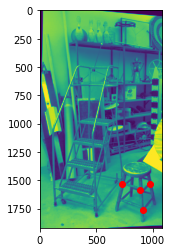

In [59]:
#P_trans @ world_pts
reprojected = P_trans @ np.hstack((world_pts,np.ones((world_pts.shape[0],1)))).T
reprojected = reprojected.T
repr0 = reprojected[:,0] / reprojected[:,-1]
repr1 = reprojected[:,1] / reprojected[:,-1]
repr = np.vstack((repr0,repr1)).T

plt.imshow(im[:,:,0])
plt.scatter(repr[:,0],repr[:,1], c="r")

they are on the same position thus the calibration is intrinsically valid

### Manual Filter

The idea now is to calculate all possible positions for all 3-cps combinations and select the position the generalizes the best to the other cps as an additional prior

In [60]:
import cv2 
from itertools import combinations

pt_idx = range(len(list(world_pts)))
combs = combinations(pt_idx,3)
possible_solutions = []
for comb in combs:
    comb = list(comb)
    world_batch = world_pts[comb,:]
    world_batch = np.ascontiguousarray(world_batch)
    image_batch = cps[comb,:2]
    image_batch = np.ascontiguousarray(image_batch).reshape((image_batch.shape[0],1,2))

    distCoeffs = np.array([[0, 0, 0, 0]]).astype("float32")
    retval, rvecs, tvecs = cv2.solveP3P(world_batch.astype("float32"), image_batch.astype("float32"), cam.astype("float32"), distCoeffs, flags=cv2.SOLVEPNP_AP3P)

    n_sol = len(rvecs)
    for i in range(len(rvecs)):
        possible_solutions.append((rvecs[i],tvecs[i]))


print(f"found {len(possible_solutions)} solutions")

possible_poses = []
for sol in possible_solutions:
    rvec, tvec = sol
    R,_ = cv2.Rodrigues(rvec)
    T = tvec
    camera_extrinsic_matrix = np.hstack((R,T))
    camera_extrinsic_matrix_hat = np.vstack((camera_extrinsic_matrix,[0,0,0,1]))
    camera_pose_matrix = la.inv(camera_extrinsic_matrix_hat)[:3,:]
    possible_poses.append(camera_pose_matrix)


print(f"example pose:\n{possible_poses[0]}")

found 12 solutions
example pose:
[[      1.00      -0.04      -0.01     148.89]
 [      0.05       1.00       0.01      44.74]
 [      0.01      -0.01       1.00     325.01]]


In [61]:
ts = []
for pose in possible_poses:
    T = pose[:,-1]
    ts.append(T)

ts = np.array(ts)
ts_mesh = pv.PolyData(ts)


compare reprojection error for poses for all points (not only the 3 that the pose is optimized for)

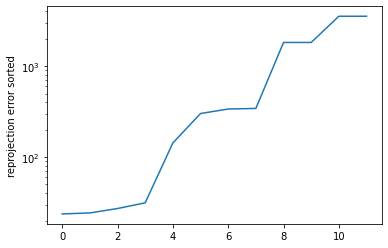

In [62]:
world_pts_hat = np.hstack((world_pts, np.ones((world_pts.shape[0],1)))).T
repr_errs = []
for i in range(len(possible_poses)):
    pose = possible_poses[i]
    pose_hat = np.vstack((pose,[0,0,0,1]))

    extr = la.inv(pose_hat)[:3,:]
    P = cam @ extr

    reprojected = P @ world_pts_hat
    reprojected = reprojected.T
    repr0 = reprojected[:,0] / reprojected[:,-1]
    repr1 = reprojected[:,1] / reprojected[:,-1]
    repr = np.vstack((repr0,repr1)).T
    repr_err = np.sum(abs(repr - cps[:,:2]))
    repr_errs.append(repr_err)

repr_errs = np.array(repr_errs)


ts_mesh["log_errors"] = np.log(repr_errs)

pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True, point_size=0.5)
pl.add_mesh(ts_mesh, scalars="log_errors", point_size=10, render_points_as_spheres=True)
pl.show()

repr_errs_sorted = np.sort(repr_errs)

plt.figure()
plt.plot(np.arange(repr_errs_sorted.shape[0]),repr_errs_sorted[:])
plt.ylabel("reprojection error sorted")
plt.gca().set_yscale('log')
plt.show()



if the result was not stable enough we could additionally select only the largest cluster as possibly valid solutions

In [63]:
#from sklearn.cluster import AgglomerativeClustering
#
##X =np.log(repr_errs).reshape((-1,1))
#X = ts
#clustering = AgglomerativeClustering(n_clusters=None,linkage="ward",distance_threshold=np.sum(np.std(ts))).fit(X)
#
#
#ts_mesh["cluster"] = clustering.labels_
#
#pl = pv.Plotter(off_screen=False,notebook=False)
#pl.add_mesh(mesh, scalars="colors",rgb=True, render_points_as_spheres=True)
#pl.add_mesh(ts_mesh, scalars="cluster", point_size=10, render_points_as_spheres=True)
#pl.show()


#### manual filtering result

In [64]:
min_err = np.inf
min_i = None
for i in range(repr_errs.shape[0]):
    err = repr_errs[i]
    if err < min_err:
        min_err = err
        min_i = i

print(f"best pose {min_i}, error {min_err}:\n{possible_poses[min_i]}")
best_pose = possible_poses[min_i]
best_pose
T_best = best_pose[:,-1]




best pose 0, error 23.69573569396448:
[[      1.00      -0.04      -0.01     148.89]
 [      0.05       1.00       0.01      44.74]
 [      0.01      -0.01       1.00     325.01]]


In [65]:
pos_truth = la.null_space(P_gt) / la.null_space(P_gt)[-1]
pos_truth = pos_truth[:3].flatten()

pl = pv.Plotter(off_screen=False,notebook=False)
sv_est = pv.Sphere(center=T_best,radius=500)
sv_gt = pv.Sphere(center=pos_truth,radius= 500)
pl.add_mesh(mesh, scalars="colors",rgb=True, point_size=0.5)
pl.add_mesh(ts_mesh, scalars="log_errors", point_size=15, render_points_as_spheres=True)
pl.add_mesh(sv_est, color="blue")
pl.add_mesh(sv_gt, color="green")
pl.show()

compare solvePnP implementation with above result

In [66]:
from src.pycv.perspective import solve_PnP

pose = solve_PnP(world_pts, cps[:,:2], cam)
pose

array([[      1.00,      -0.04,      -0.01,     148.89],
       [      0.05,       1.00,       0.01,      44.74],
       [      0.01,      -0.01,       1.00,     325.01]])

mean from best + std does not appear to work:

In [67]:
#best2x_idx = []
#stderr = np.std(repr_errs)
#for i in range(repr_errs.shape[0]):
#    err = repr_errs[i]
#    if err >= min_err + stderr:
#        best2x_idx.append(i)
#
#best2x_idx = np.array(best2x_idx)
#
#tst = ts[best2x_idx].mean(axis=0)
#print(ts[best2x_idx])
#print(tst)
#
#pl = pv.Plotter(off_screen=False,notebook=False)
#sv_est = pv.Sphere(center=T_best,radius=500)
#sv_gt = pv.Sphere(center=pos_truth,radius=500)
#sv_tst = pv.Sphere(center=tst,radius=500)
#pl.add_mesh(mesh, scalars="colors",rgb=True, point_size=0.5)
#pl.add_mesh(ts_mesh, scalars="log_errors", point_size=5, render_points_as_spheres=True)
#pl.add_mesh(sv_est, color="lightblue")
#pl.add_mesh(sv_gt, color="lightgreen")
#pl.add_mesh(sv_tst, color="white")
#pl.show()